In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_2dm_34 as fresnel
import apra_pop_models.fraunhofer_2dm_34 as fraunhofer
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3
import apra_pop_models.efc_2dm as efc
import apra_pop_models.efc_utils as efc_utils


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


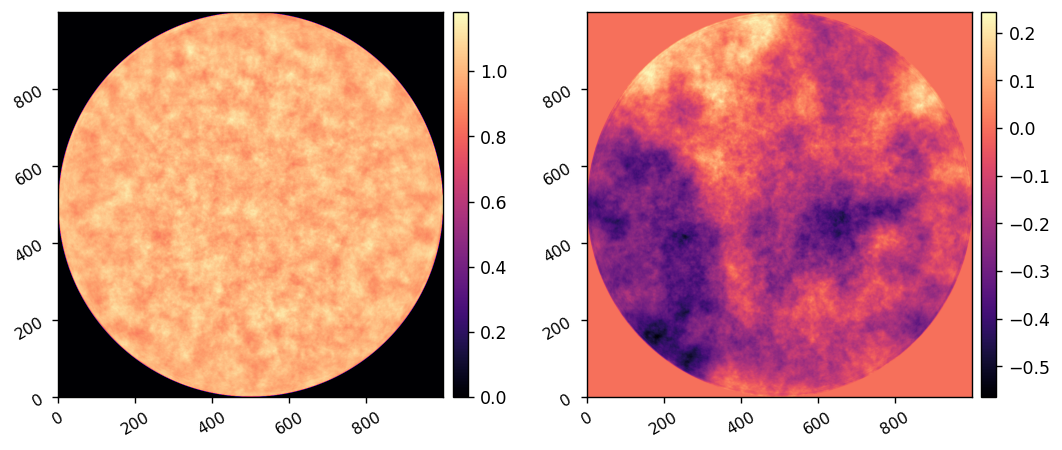

In [2]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

WFE = I.calc_pupil()
imshow2(xp.abs(WFE), xp.angle(WFE))

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


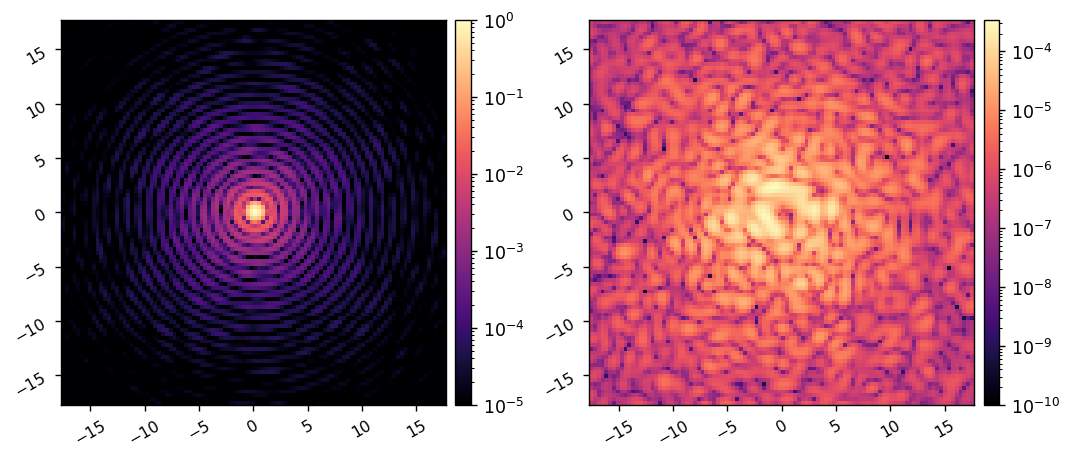

In [3]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

I.use_vortex = False
ref_psf = I.snap()
I.Imax_ref = xp.max(ref_psf)
ref_psf /= I.Imax_ref
I.use_vortex = True
ref_coro_im = I.snap()

imshow2(ref_psf, ref_coro_im,
        pxscl=I.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-10)

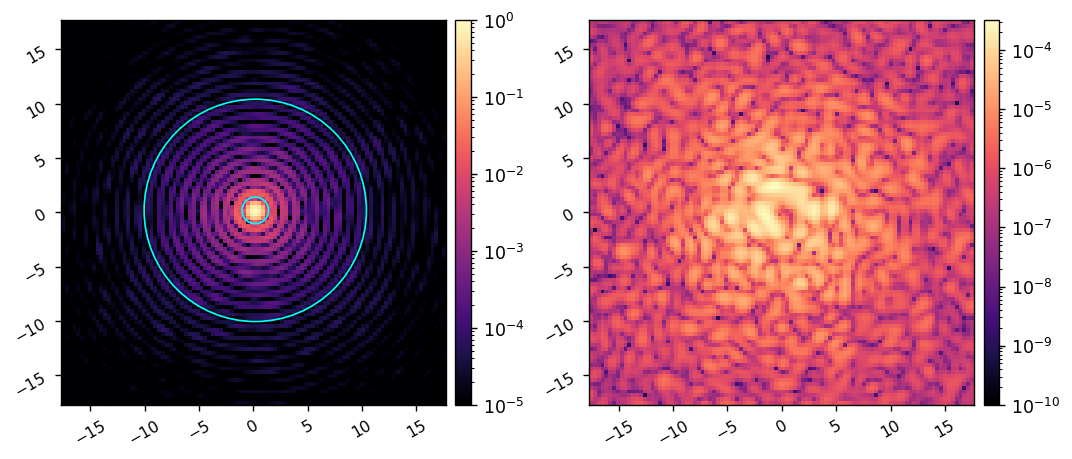

In [4]:
reload(fraunhofer)
M = fraunhofer.MODEL()
M.WFE = WFE

M.flip_dm = True
M.flip_lyot = True

acts = np.zeros(M.Nacts)

model_psf = xp.abs( M.forward(acts, use_vortex=False) )**2
M.Imax_ref = xp.max(model_psf)
model_psf /= M.Imax_ref
model_coro_im = xp.abs( M.forward(acts, use_vortex=True) )**2

psf_center = (M.psf_pixelscale_lamD/2, M.psf_pixelscale_lamD/2)
imshow2(model_psf, model_coro_im, lognorm=True, vmin1=1e-5, vmin2=1e-10, 
        pxscl=M.psf_pixelscale_lamD, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='cyan'), Circle(psf_center, 10.22, fill=False, color='cyan')])




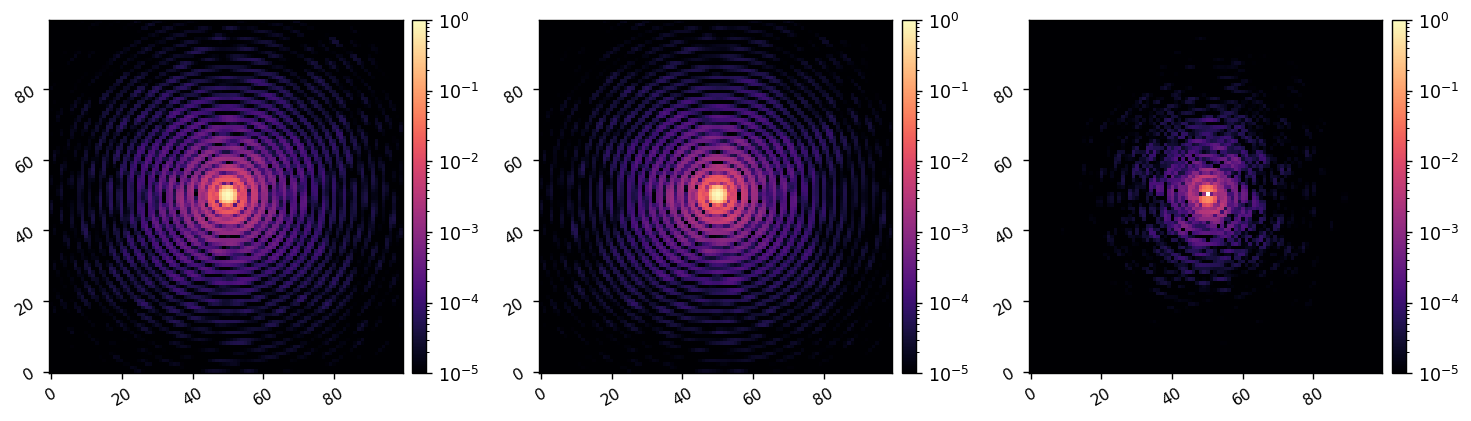

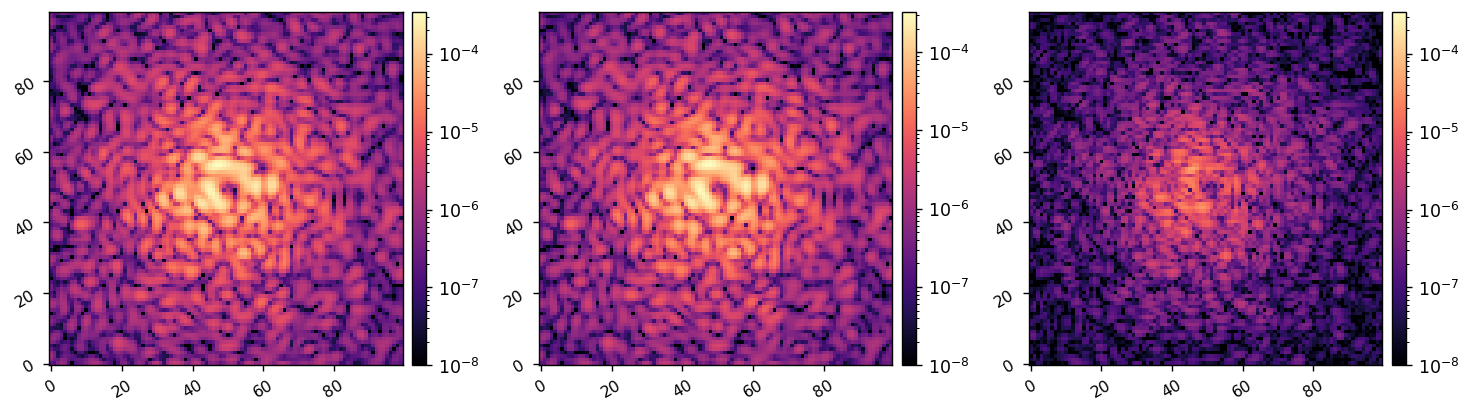

In [5]:
imshow3(ref_psf, model_psf, xp.abs(ref_psf - model_psf), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=1, 
        vmin1=1e-5, vmin2=1e-5, vmin3=1e-5)

imshow3(ref_coro_im, model_coro_im, xp.abs(ref_coro_im - model_coro_im), 
        lognorm1=True, lognorm2=True, lognorm3=True, vmax3=xp.max(ref_coro_im), 
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

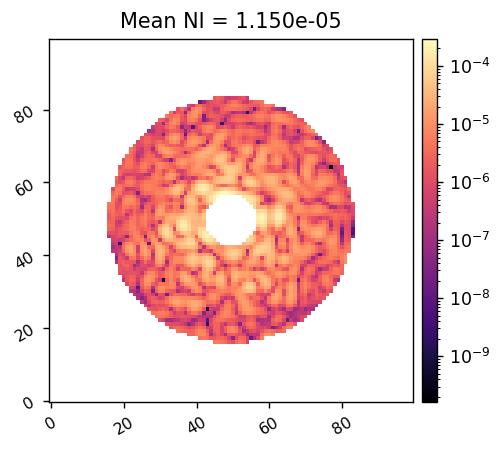

In [6]:
reload(efc_utils)
I.zero_dms()
iwa = 2.5
owa = 12
rot = 0
control_mask = efc_utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=None, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

imshow1(ref_coro_im*control_mask, f'Mean NI = {mean_ni:.3e}', lognorm=True)

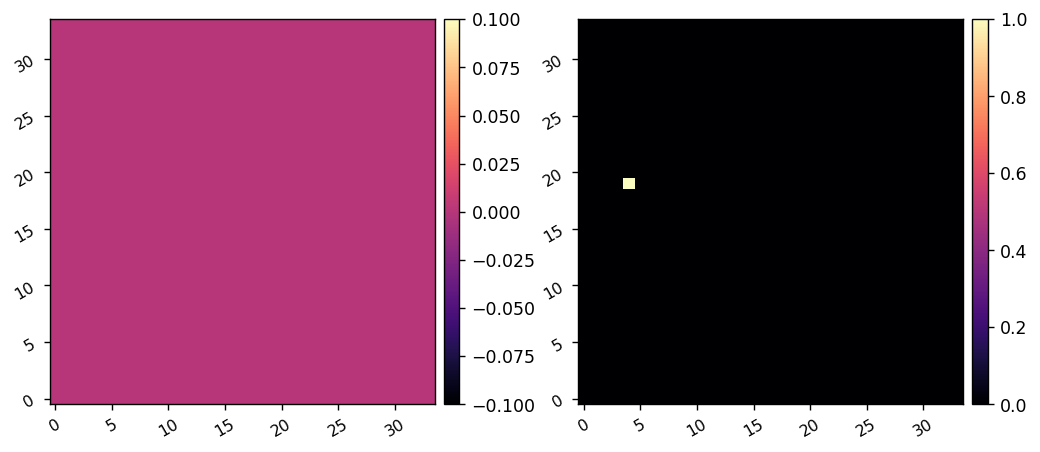

In [6]:
reload(efc_utils)
poke_modes = efc_utils.create_all_poke_modes(M.dm_mask, ndms=2)

imshow2(poke_modes[1500][:M.Nact**2].reshape(M.Nact, M.Nact), poke_modes[1500][M.Nact**2:].reshape(M.Nact, M.Nact))

In [ ]:
reload(efc)
M.zero_dms()
jac = efc.compute_jacobian(M, 1e-9, poke_modes, control_mask, plot_responses=True,)

In [88]:
utils.save_fits('../jacobians/jac.fits', jac)

Saved data to:  ../jacobians/jac.fits


In [7]:
reload(utils)
jac = utils.load_fits('../jacobians/jac.fits')

# Run EFC without PWP

In [8]:
I.zero_dms()
all_ims = []
all_efs = []
all_commands = []


Beginning closed-loop EFC simulation.
	Running iteration 4/6.
	Mean NI of this iteration: 7.282e-08


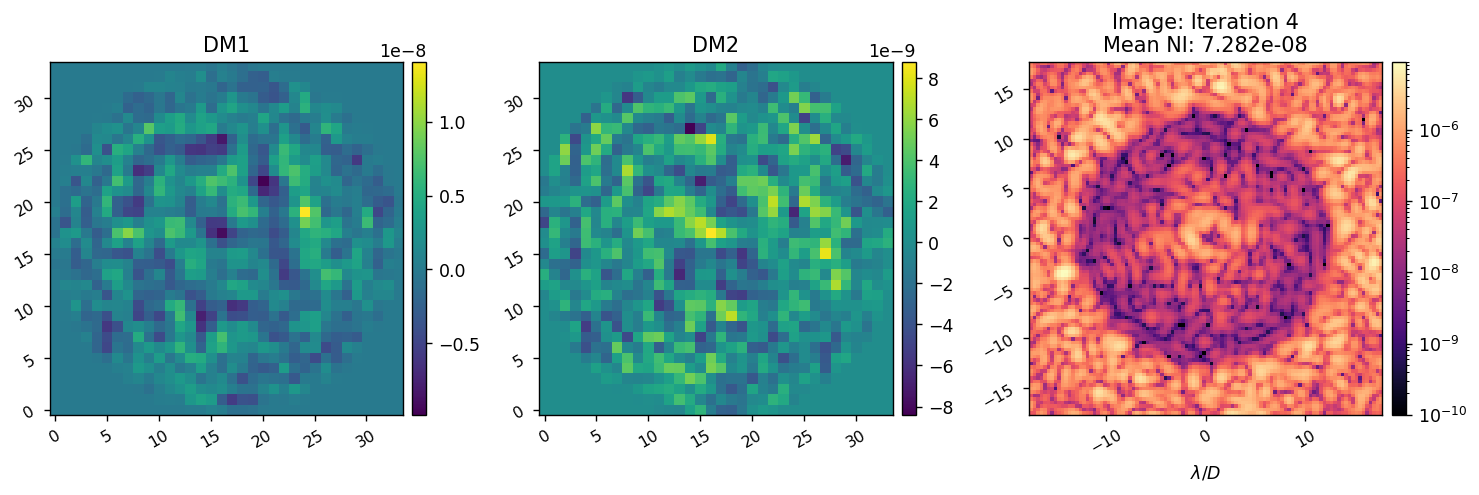

	Running iteration 5/6.
	Mean NI of this iteration: 2.519e-08


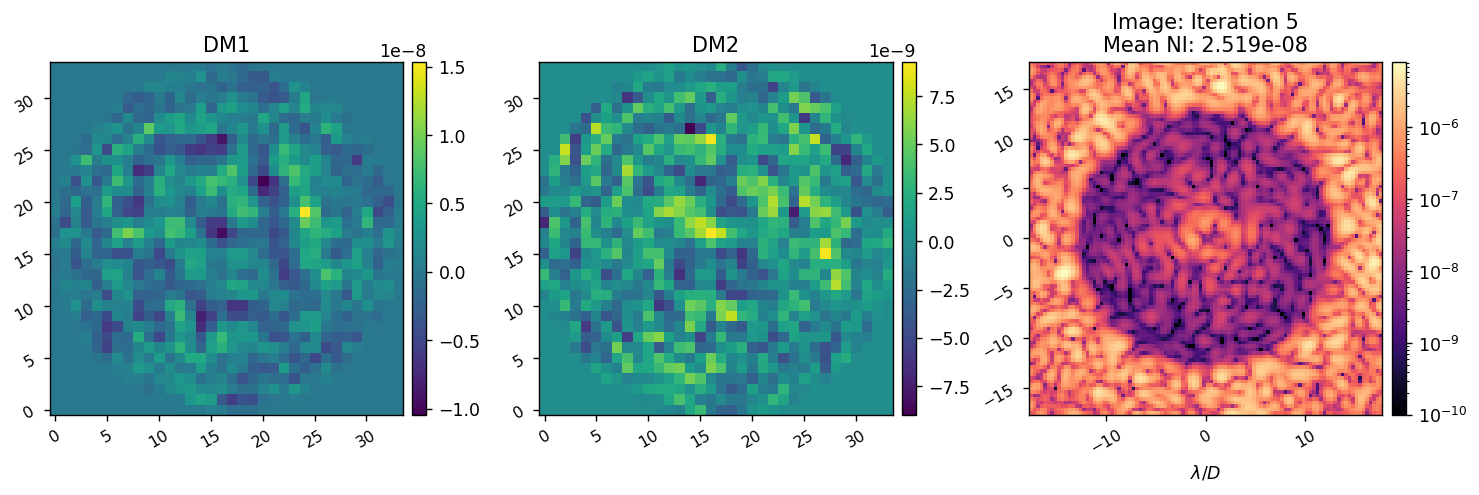

	Running iteration 6/6.
	Mean NI of this iteration: 9.504e-09


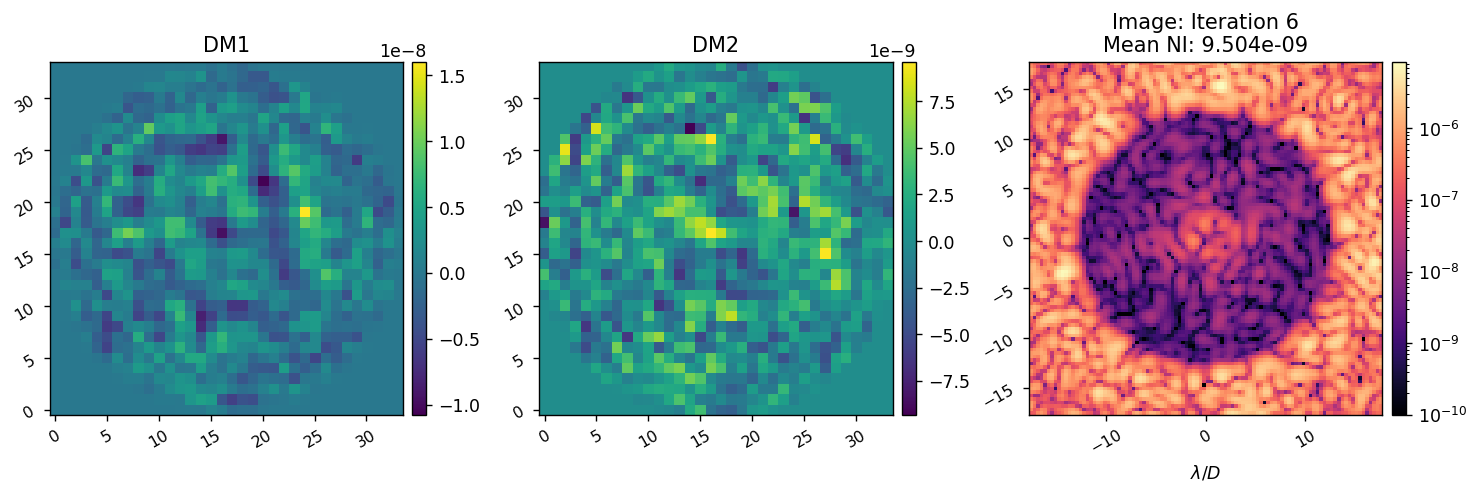

In [11]:
reload(efc)

reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4.5
reg_conds = -5

all_ims, all_efs, all_commands = efc.run(I, 
                                        jac, 
                                        reg_fun, reg_conds,
                                        control_mask, 
                                        # est_fun=pwp_fun, est_params=pwp_params,
                                        gain=0.5, 
                                        iterations=3, 
                                        plot_all=True, 
                                        all_ims=all_ims,
                                        all_efs=all_efs,
                                        all_commands=all_commands,
                                        )

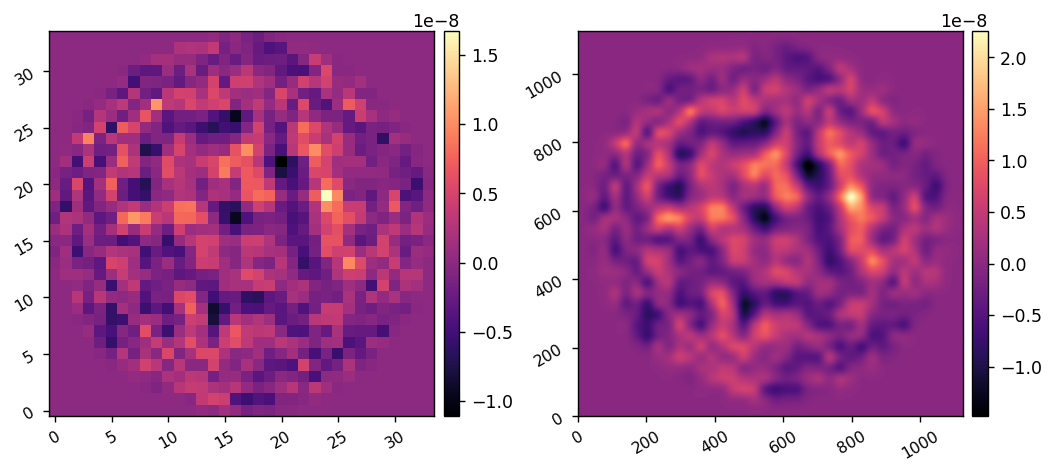

In [86]:
imshow2(I.get_dm1(), I.DM1.get_surface())

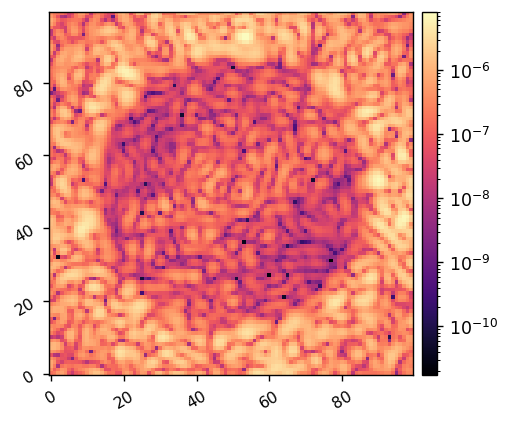

In [83]:
M.set_dm1(I.get_dm1())
M.set_dm2(I.get_dm2())

model_im = M.snap()
imshow1(model_im, lognorm=True)